# Library import

In [2]:
# import libraries

import shutil, timm, time
from tqdm import tqdm
from pprint import pprint
from timm import create_model
from fastai.vision.all import *

from astropy.visualization import simple_norm
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

# import geopandas as gpd
# occs = gpd.read_file('/mnt/c/Projects/RIO/WINU_AEM/data/external/Paterson_occs.gpkg')

import datetime
datecode = '{}-{}-{}'.format(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day)

interim_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/'
processed_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/processed/'
raw_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/raw/'
external_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/external/'

# make new folders in interim and processed directories for today's date

if os.path.join(interim_dir, datecode) not in [x[0] for x in os.walk(interim_dir)]:
    os.mkdir(os.path.join(interim_dir, datecode))
if os.path.join(processed_dir, datecode) not in [x[0] for x in os.walk(processed_dir)]:
    os.mkdir(os.path.join(processed_dir, datecode))

print(datecode)

2022-6-29


# Data import

In [3]:
QLD_EM = pd.read_csv('/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/processed/QLD_AusEM_interp.csv')

# Window parameter selection
# we want resolution to be ~1/20 or 1/30 of window width
# x interval in dataset is 10 m

window_resolution_m = 100 # x dimension sample interval in m
window_size_m = 2000 # window x dimension in m
overlap_wid_m = 500 # ~half window size - must be divisible by window_resolution

# convert m to sample counts
window_size = int(window_size_m / window_resolution_m)
overlap_wid = int(overlap_wid_m / window_resolution_m)

QLD_EM = QLD_EM.iloc[::int(window_resolution_m/20)]

## Definitions, normalisation

In [4]:
import pylab
NUM_COLORS = 15

cm = pylab.get_cmap('plasma')
color_list = []
for i in range(NUM_COLORS):
    color = cm(i/NUM_COLORS)  # color will now be an RGBA tuple
    color_list.append(color)

# 0-1 normalisation per timegate

EMZ_HPRG_list = ['EMZ_HPRG' + '[{}]'.format(i) for i in range(1,16)]
EMZ_HPRG_norm_list = [i + '_norm' for i in EMZ_HPRG_list]
EMZ_HPRG_lognorm_list = [i + '_lognorm' for i in EMZ_HPRG_list]

# 0-1 normalisation per timegate

for timegate in range(len(EMZ_HPRG_list)):
    min = QLD_EM[EMZ_HPRG_list[timegate]].min()
    max = QLD_EM[EMZ_HPRG_list[timegate]].max()
    QLD_EM[EMZ_HPRG_norm_list[timegate]] = (QLD_EM[EMZ_HPRG_list[timegate]] - min) / (max - min)
    QLD_EM[EMZ_HPRG_lognorm_list[timegate]] = np.log10(QLD_EM[EMZ_HPRG_norm_list[timegate]] + 0.00001)
    logmin = QLD_EM[EMZ_HPRG_lognorm_list[timegate]].min()
    logmax = QLD_EM[EMZ_HPRG_lognorm_list[timegate]].max()    
    QLD_EM[EMZ_HPRG_lognorm_list[timegate]] = ((QLD_EM[EMZ_HPRG_lognorm_list[timegate]] - min) / (max - min)) + 1

# Load image paths

In [7]:
# set paths to image tiles
img_path = interim_dir + '{}/tiles/'.format(file_datecode)

# read images paths into data frame 
filelist= np.array([f for f in os.listdir(img_path) if f.endswith('.png') or f.endswith('.tif')])
df = pd.DataFrame()
df['path'] = [os.path.join(img_path, x) for x in filelist]
df['labels'] = 1
# df['is_valid'] = False
# df['is_valid'][::20] = True
df['id'] = [int(stringy[-11:-4]) for stringy in df.path]
df

,path,labels,id
0,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0000000.png,1,0
1,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0000001.png,1,1
2,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0000002.png,1,2
3,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0000003.png,1,3
4,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0000004.png,1,4
...,...,...,...
60900,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0060900.png,1,60900
60901,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0060901.png,1,60901
60902,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0060902.png,1,60902
60903,/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/2022-6-29/tiles/0060903.png,1,60903


# Create dataloader

In [8]:
# create dataloader from dataframe
def create_dls(df, size=224, x_col="path", y_col="id", col_splitter=True, bs=128):
  item_tfms = [Resize(size)]
  batch_tfms = []
  if col_splitter:
    splitter = ColSplitter("is_valid")
  else:
    splitter = RandomSplitter(valid_pct=0.0, seed=36)
  # Create datablock
  rocks = DataBlock(
              blocks = (ImageBlock, CategoryBlock),
              get_x = ColReader(x_col),
              splitter = splitter,
              get_y = ColReader(y_col),
              item_tfms = item_tfms,
              batch_tfms = batch_tfms
          )
  dls = rocks.dataloaders(df,bs=bs, shuffle=False, drop_last=False)
  return dls

# define input and output functions
def get_output(module, input_value, output):
  return output.flatten(1)
def get_input(module, input_value, output):
  return list(input_value)[0]

# get layer named: name
def get_named_module_from_model(model, name):
  for n, m in model.named_modules():
    if n == name:
      return m
  return None

# hook to last fully connect layer
class Hook():
  "Create a hook on `m` with `hook_func`."
  def __init__(self, m:nn.Module, hook_func, is_forward:bool=True, detach:bool=True):
    self.hook_func,self.detach,self.stored = hook_func,detach,None
    f = m.register_forward_hook if is_forward else m.register_backward_hook
    self.hook = f(self.hook_fn)
    self.removed = False

  def hook_fn(self, module:nn.Module, input, output):
    "Applies `hook_func` to `module`, `input`, `output`."
    if self.detach:
      input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
      output = (o.detach() for o in output) if is_listy(output) else output.detach()
    self.stored = self.hook_func(module, input, output)

  def remove(self):
    "Remove the hook from the model."
    if not self.removed:
      self.hook.remove()
      self.removed=True

  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()

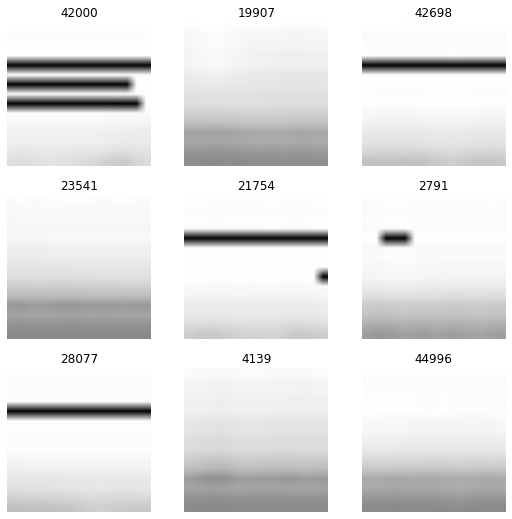

In [9]:
# define batch size
bs = 12

# create dataloader for feature extraction
dls = create_dls(df,col_splitter=False, bs=bs)

dls.show_batch()

# Prepare model

In [10]:
# list model names
model_names = timm.list_models('*efficientnetv2*',pretrained=True)
pprint(model_names)

['efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k',
 'tf_efficientnetv2_xl_in21ft1k',
 'tf_efficientnetv2_xl_in21k']


In [11]:
# define body
base_model_name = 'efficientnetv2_rw_s'

# get the body
body = create_model(base_model_name, pretrained=True, in_chans=3, num_classes=0)
new_body = nn.Sequential(*list(body.children())[:-2])
nf = num_features_model(nn.Sequential(*body.children())) 

# define head and model
head = create_head(nf, dls.c)
model = nn.Sequential(new_body, head)

# initialise weight and create learner
apply_init(model[1], nn.init.kaiming_normal_)
learner = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

# get model and copy it to GPU
model = learner.model
model.cuda()
linear_output_layer = get_named_module_from_model(model, "1.4")
print("Finished prepare model!")

Finished prepare model!


# Feature extraction

In [13]:
# run feature extraction procedure
img_repr_map = {}
# start_time = time.time()
print("Generating feature map ...")
total = 0
with Hook(linear_output_layer, get_output, True, True) as hook:
    # start = time.time()
    for i, (xb, yb) in tqdm(enumerate(dls[0])):
        cur_bs = xb.shape[0]
        end = i*bs + cur_bs
        img_ids = dls[0].items[i*bs:end].path.values
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(cur_bs, -1)
        for j in range(cur_bs):
            img_repr_map[img_ids[j]] = img_reprs[j]
        # if(len(img_repr_map) % 1280 == 0):
            # end = time.time()
            # print(f'{end-start} secs for 1280 images')
            # start = end

# place features in a data frame
# print("Total processing time: ", time.time()-start_time)
df_feature = pd.DataFrame(img_repr_map.items(), columns=['path', 'feature']).sort_values('path')

data = np.vstack(df_feature['feature'].values)

# save to disk
with open(interim_dir + '{}/QLD_AusEM_CNN-features_{}m-window_stack.pickle'.format(file_datecode, window_size_m), 'wb') as handle:
    pickle.dump(data, handle, protocol=4)

Generating feature map ...


5076it [42:16,  2.00it/s]
